# SPKIR CG data deep dive 1.4

In this notebook we display OOI SPKIR data stored in the kdata drive for certain deployments that may need additional annotations. Ref Des: GI01SUMO-RID16-08-SPKIRB000

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm

from ooi_data_explorations.common import list_methods, list_streams, get_annotations, add_annotation_qc_flags, load_kdata, get_vocabulary, update_dataset
from ooi_data_explorations.uncabled.process_spkir import spkir_datalogger
from ooinet.M2M import get_deployments
from qartod_testing.data_deep_dive import nanfill_time_gaps, check_chla_swr, compare_spkir_to_ctdbp

In [2]:
# Set parameters for data request 
refdes = 'GI01SUMO-RID16-08-SPKIRB000'
site, node, sensor = refdes.split('-', 2)

In [3]:
# Set parameters for co-located FLORT
flort_node = 'RID16'

In [4]:
# Set parameter for SPKIR internal temperature comparison with co-located CTDBP sea water temperature
ctdbp_node = 'RID16'
ctdbp_sensor = '03-CTDBPF000'

### Check data delivery methods, deployments, and annotations

In [5]:
# Create dict of methods and associated data streams
methods = list_methods(site, node, sensor)

streams = {}
for method in methods:
    streams[method] = list_streams(site, node, sensor, method)

streams

{'recovered_host': ['spkir_abj_dcl_instrument_recovered'],
 'telemetered': ['spkir_abj_dcl_instrument']}

In [6]:
# View deployment information
deployments = get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-SPKIRB-00240,2450,59.9337,-39.47378,12.0,2014-09-10 18:50:00,2015-08-22 11:00:00,KN221-04,AT30-01
1,2,CGINS-SPKIRB-00275,1485,59.94358,-39.57372,12.0,2015-08-15 19:22:00,2016-07-19 10:09:00,AT30-01,AR7-01
2,3,CGINS-SPKIRB-00240,2450,59.9341,-39.4673,12.0,2016-07-10 17:44:00,2017-08-14 09:33:00,AR7-01,AR21
3,4,CGINS-SPKIRB-00288,1388,59.9449,-39.5751,12.0,2017-08-05 18:17:00,2017-10-12 09:07:00,AR21,AR30-03
4,5,CGINS-SPKIRB-00240,2450,59.93295,-39.46549,12.0,2018-06-08 17:21:00,2019-08-09 08:04:00,AR30-03,AR35-05
5,6,CGINS-SPKIRB-00275,1485,59.945118,-39.57401,12.0,2019-08-05 15:29:00,2020-08-26 10:41:00,AR35-05,AR46
6,7,CGINS-SPKIRB-00239,2546,59.935683,-39.471917,12.0,2020-08-17 17:34:00,2021-08-19 06:49:00,AR46,AR60-01
7,8,CGINS-SPKIRB-00271,1476,59.946233,-39.57565,12.0,2021-08-12 17:04:00,2022-07-06 08:32:00,AR60-01,AR69-01
8,9,CGINS-SPKIRB-00288,1388,59.936183,-39.470155,12.0,2022-06-30 15:54:00,2023-09-10 10:12:00,AR69-01,AR76-03
9,10,CGINS-SPKIRB-00300,1943,59.944783,-39.5736,12.0,2023-08-31 16:00:00,NaT,AR76-03,None


In [7]:
## View annotations
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)

if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

annotations
# annotations['annotation'][5]

# Note: now I have moved the lines that add a human-readable date time up here where the annotations are displayed, however I'm not sure if the begin and endDT columns still need 
# to exist. I would like to remove them because they are just taking up space and don't add anything to the dataFrame displayed below.

,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters,beginDate,endDate
0,46,GI01SUMO,None,None,None,None,1423958400000,1.440202e+12,Deployment 1: Status data sent from the buoy i...,False,lgarzio@marine.rutgers.edu,None,[],2015-02-15T00:00:00,2015-08-22T00:00:00
1,47,GI01SUMO,None,None,None,None,1453852800000,1.468886e+12,Deployment 2: A period of violent weather caus...,False,lgarzio@marine.rutgers.edu,None,[],2016-01-27T00:00:00,2016-07-19T00:00:00
2,121,GI01SUMO,None,None,None,None,1482796800000,1.491523e+12,Deployment 3: Wind turbines were disabled due ...,False,lgarzio@marine.rutgers.edu,None,[],2016-12-27T00:00:00,2017-04-07T00:00:00
3,2407,GI01SUMO,RID16,None,None,None,1604696400000,1.605017e+12,Deployment 7: * UPDATED 2020-11-12: The NSIF w...,False,cdobson@whoi.edu,not_operational,[],2020-11-06T21:00:00,2020-11-10T14:00:00
4,687,GI01SUMO,RID16,08-SPKIRB000,None,None,1410375000000,1.421574e+12,Deployment 1: The copper shutter was missing a...,False,lgarzio@marine.rutgers.edu,None,[],2014-09-10T18:50:00,2015-01-18T09:35:00
5,705,GI01SUMO,RID16,08-SPKIRB000,None,None,1468172640000,1.502703e+12,Deployment 3: The bioshutter paddle was missin...,False,lgarzio@marine.rutgers.edu,None,[],2016-07-10T17:44:00,2017-08-14T09:33:00
6,102,GI01SUMO,None,None,None,None,1501957020000,1.528963e+12,Deployment 4: at 10:03 UTC on 12 October 2017 ...,False,lgarzio@marine.rutgers.edu,None,[],2017-08-05T18:17:00,2018-06-14T08:02:00
7,1743,GI01SUMO,None,None,telemetered,None,1571702400000,1.598438e+12,Deployment 6: *UPDATED 2020-04-27: As of 2020-...,False,cdobson@whoi.edu,None,[],2019-10-22T00:00:00,2020-08-26T10:41:00
8,1625,GI01SUMO,None,None,None,None,1560988800000,1.565338e+12,Deployment 5: Battery voltage dropped below 24...,False,cdobson@whoi.edu,None,[],2019-06-20T00:00:00,2019-08-09T08:04:00
9,2254,GI01SUMO,RID16,None,None,None,1593475200000,1.596154e+12,Deployment 6: Due to power generation concerns...,False,cdobson@whoi.edu,not_operational,[],2020-06-30T00:00:00,2020-07-31T00:00:00


In [20]:
annotations['annotation'][5]

'Deployment 3: The bioshutter paddle was missing at recovery.'

### Deployment 3

2nd brief period of sampling at end looked like biofouling. After comparing with the Chl-a estimate and downwelling SWR it is less clear whether that data has been affected by biofouling. Around the same time the SPKIR sampling, the Chl-a concentration estimate shows a small peak, and SWR temporarily drops. Now I doubt that we need an annotation for the second brief period of sampling at the end of this deployment.

I was looking at co-located CTD since end of 1st brief period of sampling could be showing instrument issues. Unfortunately it did not help clarify what might be happening with the instrument for 2 reasons: 1) the CTDBP time series had 2 fill values that made the y-axis scale very large, and 2) there is no sea water temperature from the CTDBP during the data collected in the 1st brief period of sampling towards the end of the deployment.

In [9]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 3

In [10]:
# Request annotations and load data from the local kdata directory 
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


In [11]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [12]:
spkir = nanfill_time_gaps(spkir)

In [13]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 21413, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2016-07-10T17:45:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 11.5 11.5 ... 11.5
    input_voltage                  (station, time) float32 8.43 8.43 ... 8.43
    deployment                     (station, time) float32 3.0 3.0 ... 3.0 3.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.31
    raw_irradiance_412             (station, time) float32 2.158e+09 ... 2.15...
    raw_irradiance_444             (station, time) float32 2.164e+09 ... 2.15...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.08636 ... 0.4347
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'GI01SUMO'
    lat                            (station) float32 59.93
    lon                            (station) float32 -39.47
    z                              (station) float32 12.0
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            12.0
    geospatial_vertical_max:            12.0

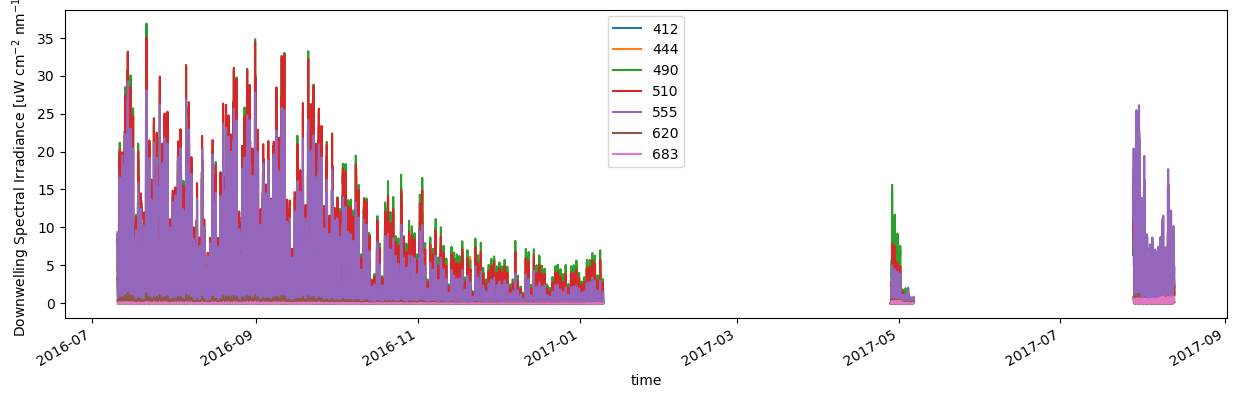

In [26]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

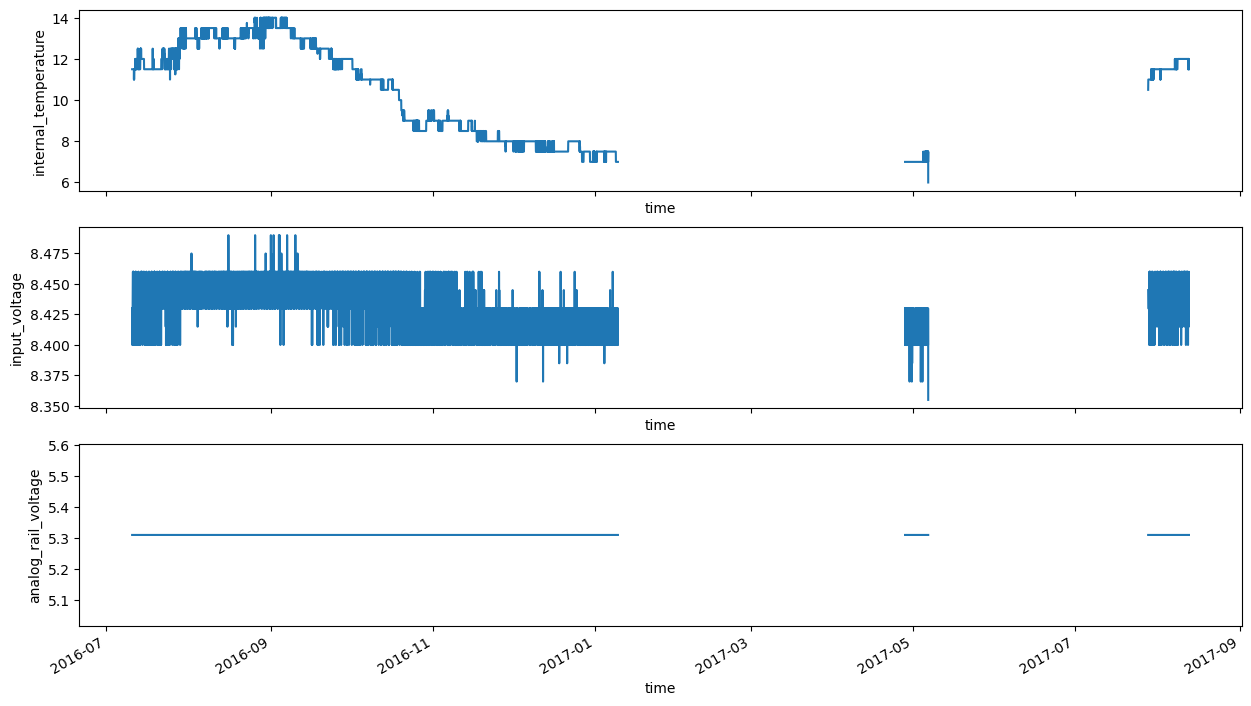

In [27]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:09<00:00,  9.68s/it]


Loading and Processing Data Files: 100%|██████████| 2/2 [00:18<00:00,  9.49s/it]


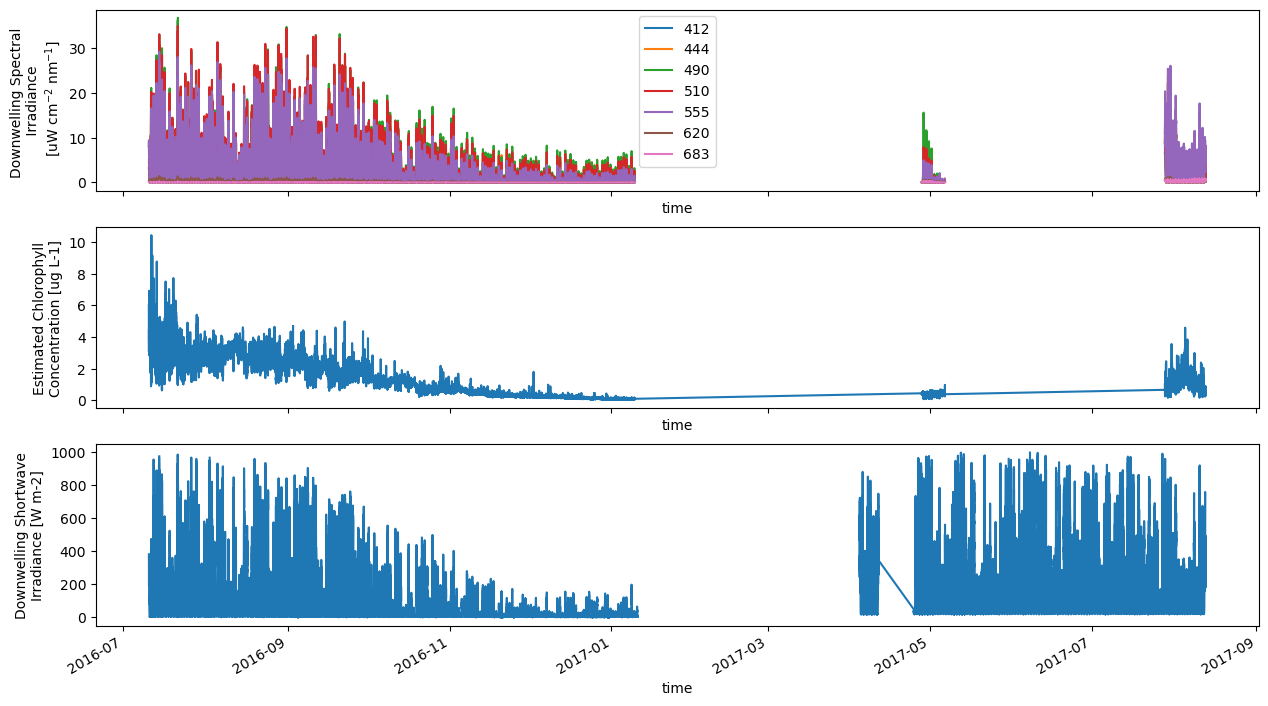

In [28]:
# Check behavior of shortwave irradiance and Chl-a during deployment
metbk, flort, fig, ax = check_chla_swr(spkir, site, deploy, flort_node)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


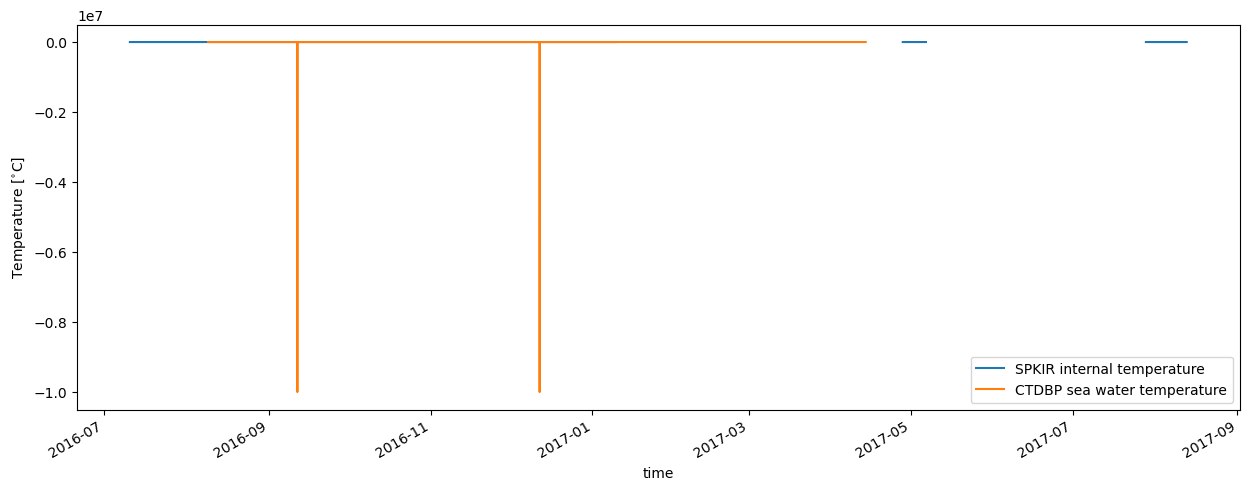

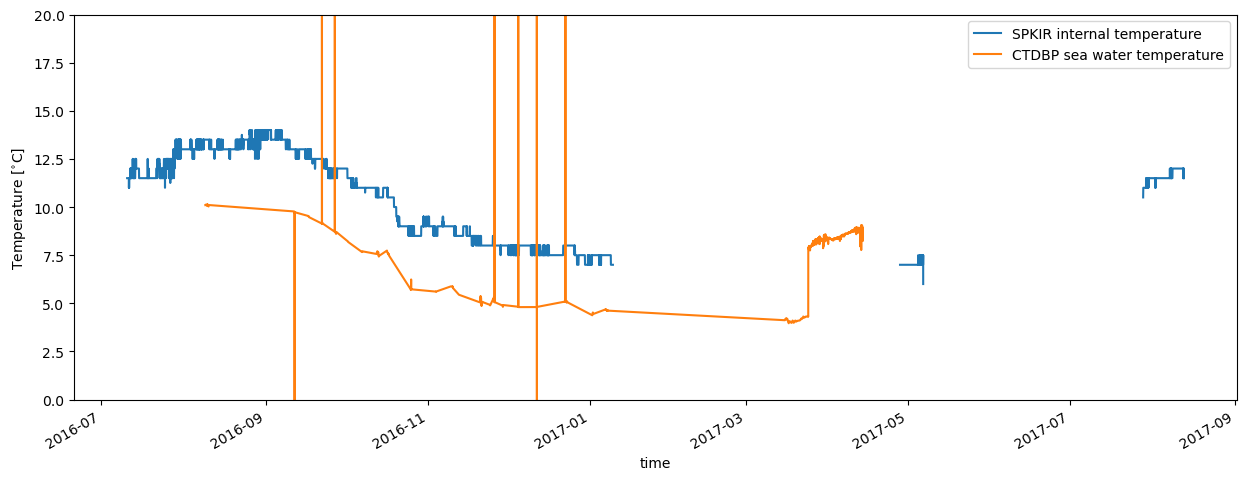

In [14]:
# Compare SPKIR internal temperature time series to sea water temperature
# to check that the instrument is performing as expected
ctdbp, fig, ax = compare_spkir_to_ctdbp(spkir, site, deploy, ctdbp_node, ctdbp_sensor)
ax.set_ylim([0, 20])
fig

In [29]:
# Find start and end dates for annotation of data recorded during long gap
# Should start 15 mins after the last data point in Jan
# and it will end 15 mins before first data point in July 2017
print(spkir.downwelling_irradiance_555.where(
    spkir.downwelling_irradiance_555.notnull(), drop=True).sel(
    time="Jan 2017").squeeze()[-1])
print(spkir.downwelling_irradiance_555.where(
    spkir.downwelling_irradiance_555.notnull(), drop=True).sel(
    time="July 2017").squeeze()[0])

<xarray.DataArray 'downwelling_irradiance_555' ()>
array(0.04967133, dtype=float32)
Coordinates:
    time     datetime64[ns] 2017-01-09T18:00:00
Attributes:
    _FillValue:               nan
    comment:                  Downwelling spectral irradiance measured at 555...
    long_name:                Downwelling Spectral Irradiance at 555 nm
    precision:                4
    coordinates:              time lon lat z
    data_product_identifier:  SPECTIR_L1-555
    units:                    uW cm-2 nm-1
    ancillary_variables:      raw_irradiance_555
    standard_name:            downwelling_photon_spherical_irradiance_per_uni...
    radiation_wavelength:     555
<xarray.DataArray 'downwelling_irradiance_555' ()>
array(11.14689, dtype=float32)
Coordinates:
    time     datetime64[ns] 2017-07-28T12:15:00
Attributes:
    _FillValue:               nan
    comment:                  Downwelling spectral irradiance measured at 555...
    long_name:                Downwelling Spectral Irradi

### Deployment 5

I checked the start of deployment 5 and the last month of the deployment for biofouling. It does not look like downwelling SWR was reduced for longer than a few days at either end. However, The Chl-a concentration estimate shows large spikes during both of these times. Now I don't think we need an annotation to mark these data as suspect.

In [14]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 5

In [15]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 2/2 [00:11<00:00,  5.88s/it]


In [16]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [17]:
spkir = nanfill_time_gaps(spkir)

In [18]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 39205, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2018-06-08T17:30:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 9.0 9.0 ... 13.5 13.5
    input_voltage                  (station, time) float32 8.4 8.4 ... 8.46 8.43
    deployment                     (station, time) float32 5.0 5.0 ... 5.0 5.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.31
    raw_irradiance_412             (station, time) float32 2.154e+09 ... 2.15...
    raw_irradiance_444             (station, time) float32 2.156e+09 ... 2.15...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.0286 ... 0.06447
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'GI01SUMO'
    lat                            (station) float32 59.93
    lon                            (station) float32 -39.47
    z                              (station) float32 12.0
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            12.0
    geospatial_vertical_max:            12.0

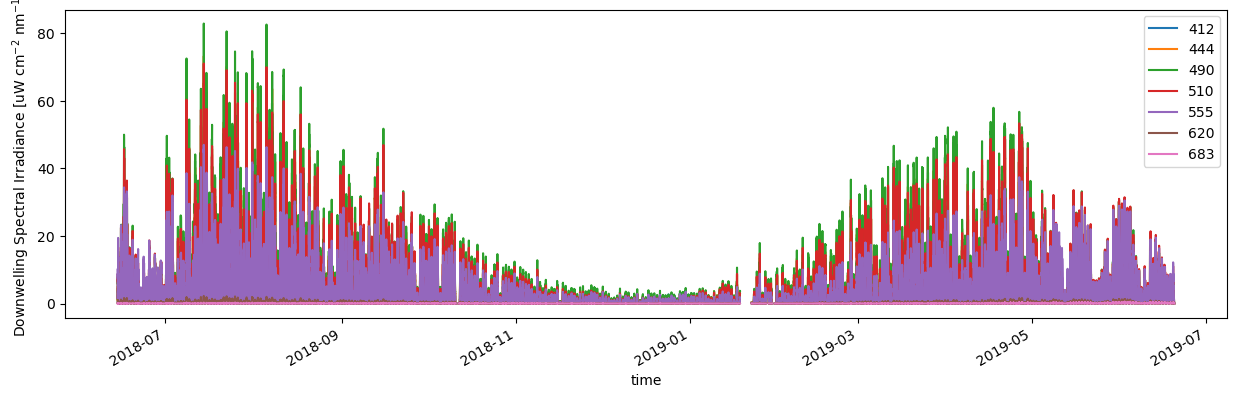

In [27]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

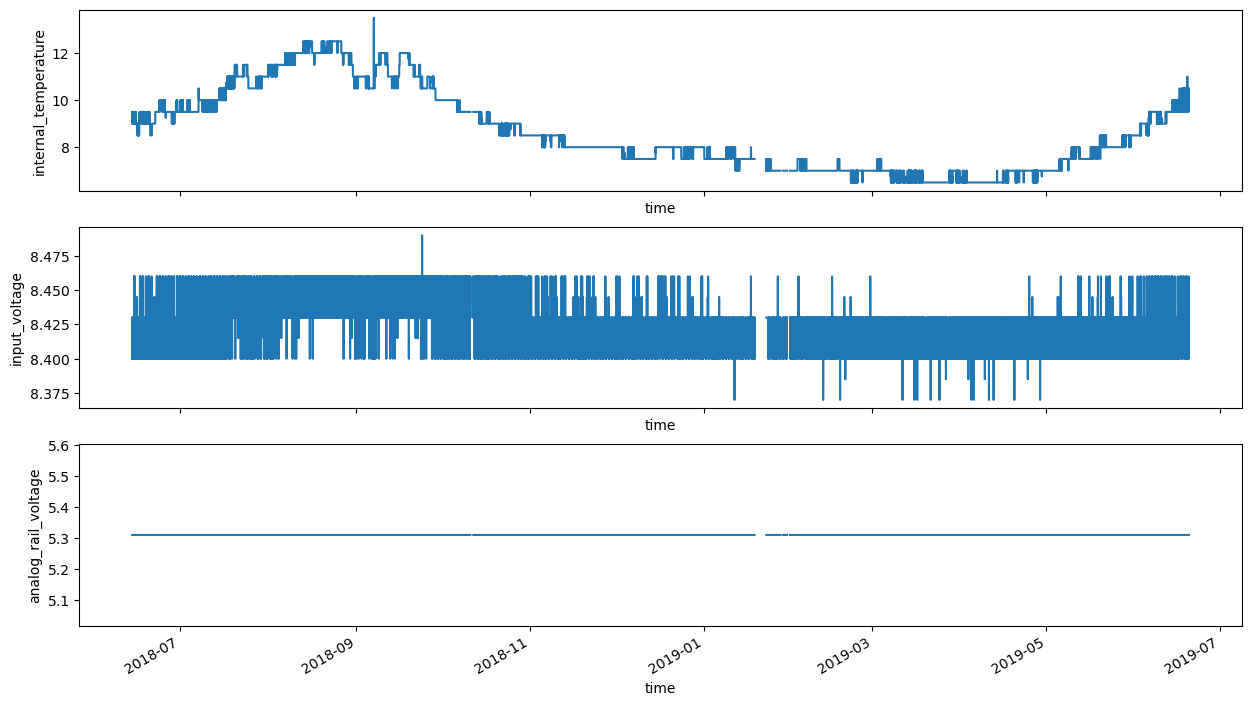

In [28]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]


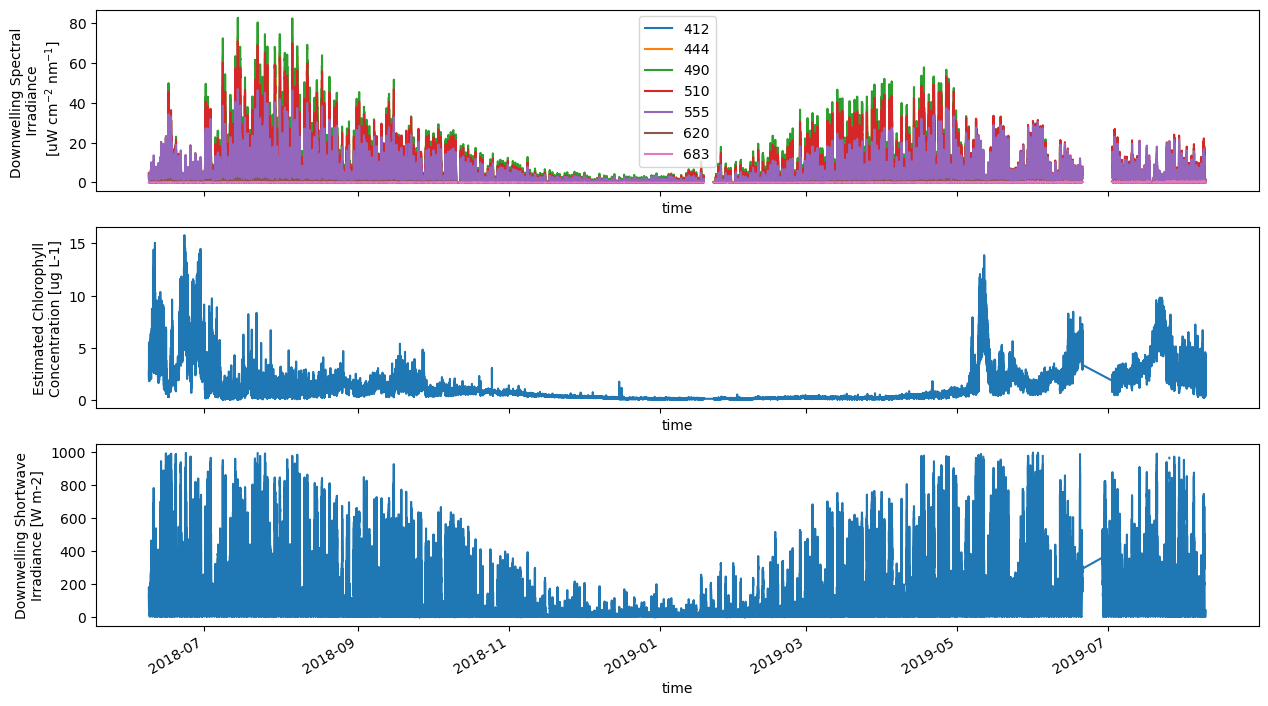

In [19]:
# Check behavior of shortwave irradiance and Chl-a during deployment
metbk, flort, fig, ax = check_chla_swr(spkir, site, deploy, flort_node)

### Deployment 6

I checked the 2 months before the NSIF was powered down for a month for biofouling. Even though the downwelling SWR was reaching values near its maximum during these two months, there are about 3 large peaks in the Chl-a concentration estimate that hint at what was reducing the downwelling spectral irradiance during that time. I would guess that there were several phytoplankton blooms in the early summer as solar irradiance was reaching its maximum. No annotation needed here. 

In [20]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 6

In [21]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 2/2 [00:10<00:00,  5.23s/it]


In [22]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [23]:
spkir = nanfill_time_gaps(spkir)

In [24]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 33854, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2019-08-05T15:30:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 14.0 14.0 ... 14.0
    input_voltage                  (station, time) float32 8.4 8.4 ... 8.4 8.4
    deployment                     (station, time) float32 6.0 6.0 ... 6.0 6.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.325
    raw_irradiance_412             (station, time) float32 2.181e+09 ... 2.18...
    raw_irradiance_444             (station, time) float32 2.199e+09 ... 2.18...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.1009 ... 0.1302
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'GI01SUMO'
    lat                            (station) float32 59.95
    lon                            (station) float32 -39.57
    z                              (station) float32 12.0
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            12.0
    geospatial_vertical_max:            12.0

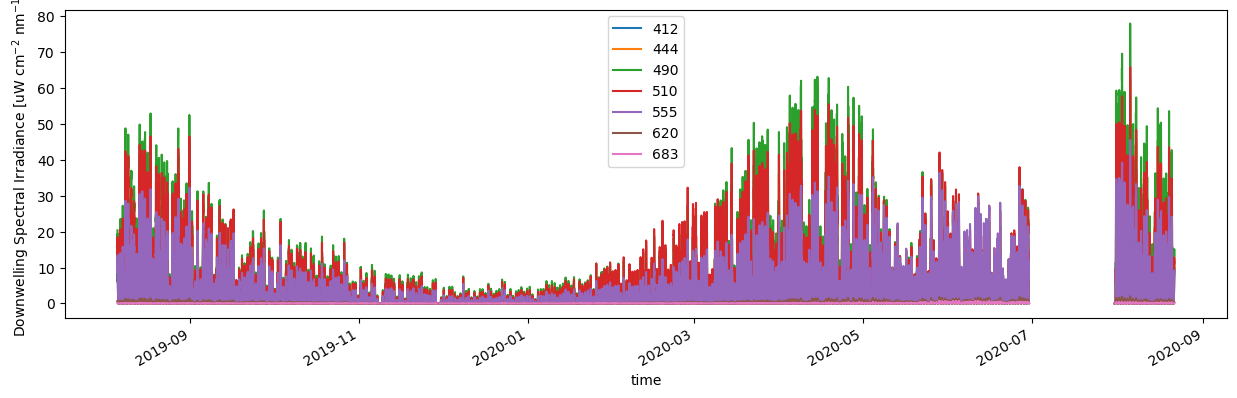

In [49]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

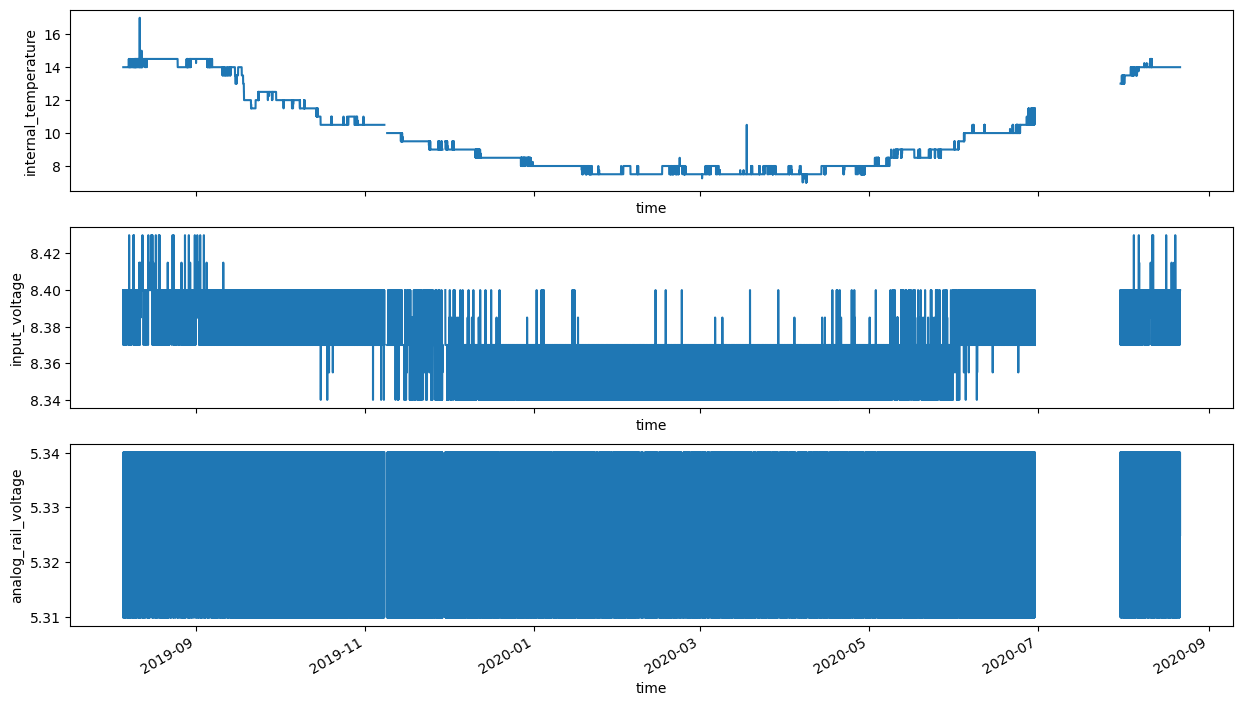

In [50]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


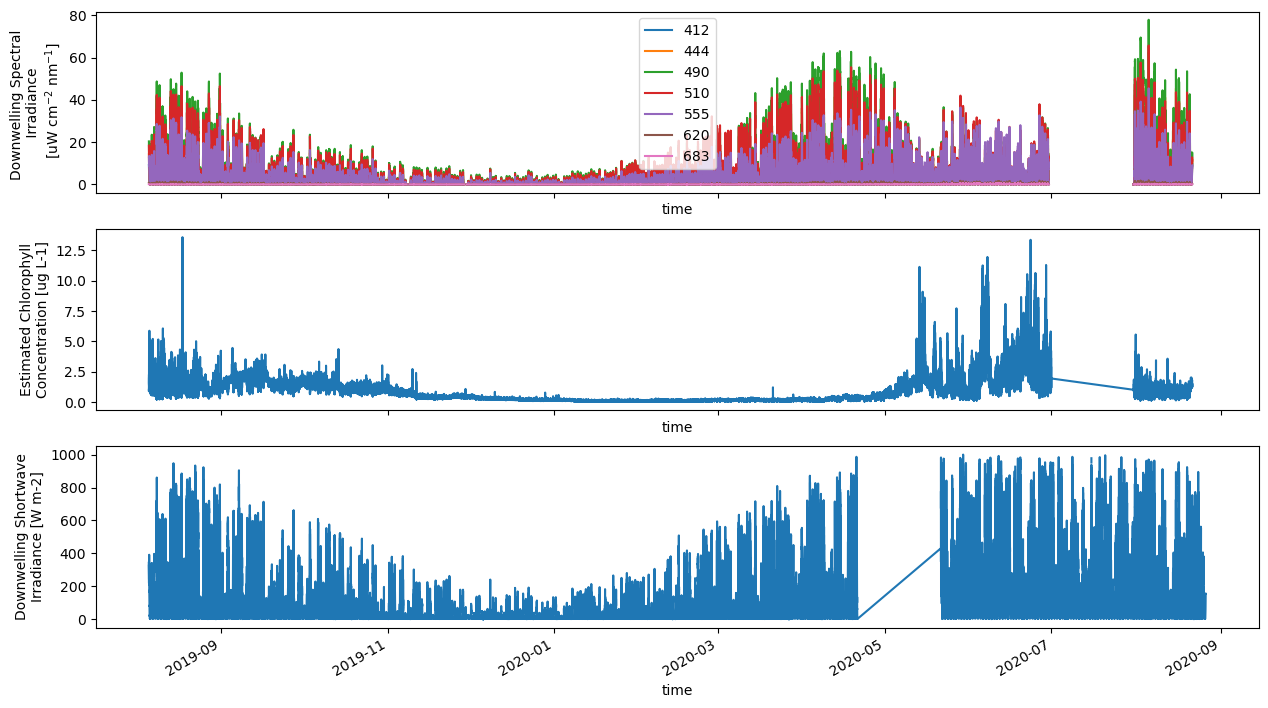

In [25]:
# Check behavior of shortwave irradiance and Chl-a during deployment
metbk, flort, fig, ax = check_chla_swr(spkir, site, deploy, flort_node)

### Deployment 7

In last couple of months of deployment 7, I thought we might be seeing effects of UV lamp power pin corroding and the gradual buildup of biofouling. Unfortunately we do not have a Chl-a estimate during the last couple of months. I would guess though that there tends to be more chlorophyll in the water during May and June as we saw in deployment 6, so that might be reducing the observed SPKIR signal. As for the very end of the record, SWR also shows a sudden drop in values, so maybe we are seeing the effects of clouds moving in overhead. I am not sure that we need an annotation anymore (partially because when I looked at the time series this time, I wasn't sure why I made a note previously). 

Deployment 8 also starts with very low values.

In [26]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 7

In [27]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 3/3 [00:10<00:00,  3.33s/it]


In [28]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [29]:
spkir = nanfill_time_gaps(spkir)

In [30]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 33455, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2020-08-17T17:45:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 12.5 12.5 ... 12.5
    input_voltage                  (station, time) float32 8.43 8.43 ... 8.43
    deployment                     (station, time) float32 7.0 7.0 ... 7.0 7.0
    analog_rail_voltage            (station, time) float32 5.28 5.31 ... 5.31
    raw_irradiance_412             (station, time) float32 2.184e+09 ... 2.14...
    raw_irradiance_444             (station, time) float32 2.195e+09 ... 2.14...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.04341 ... -0.01184
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'GI01SUMO'
    lat                            (station) float32 59.94
    lon                            (station) float32 -39.47
    z                              (station) float32 12.0
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            12.0
    geospatial_vertical_max:            12.0

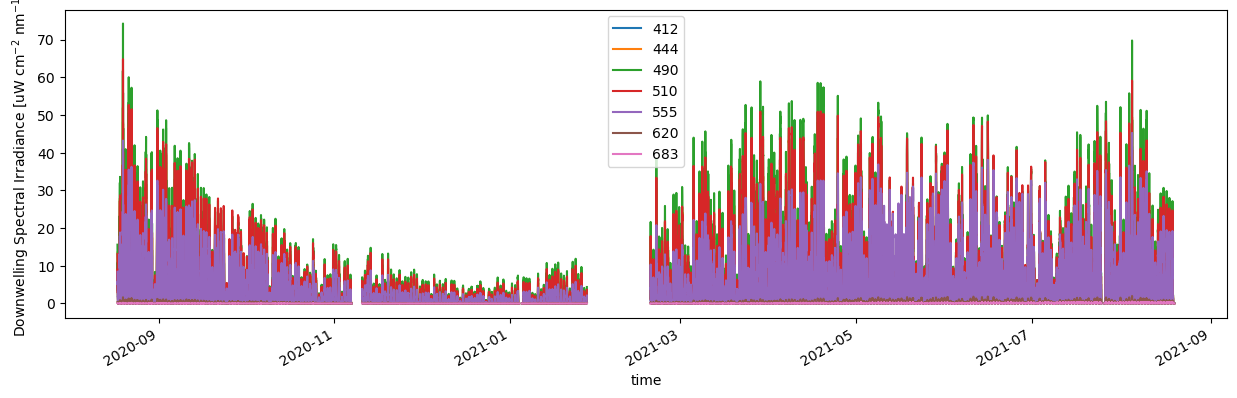

In [56]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

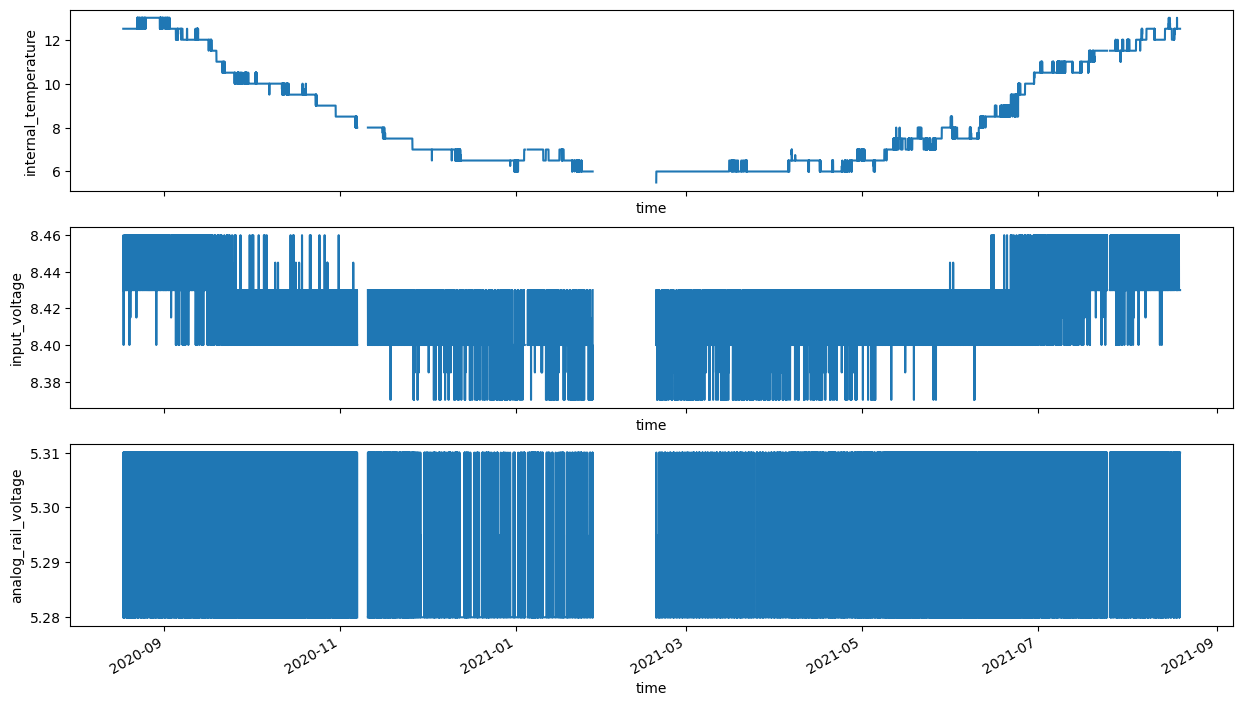

In [57]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Loading and Processing Data Files: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


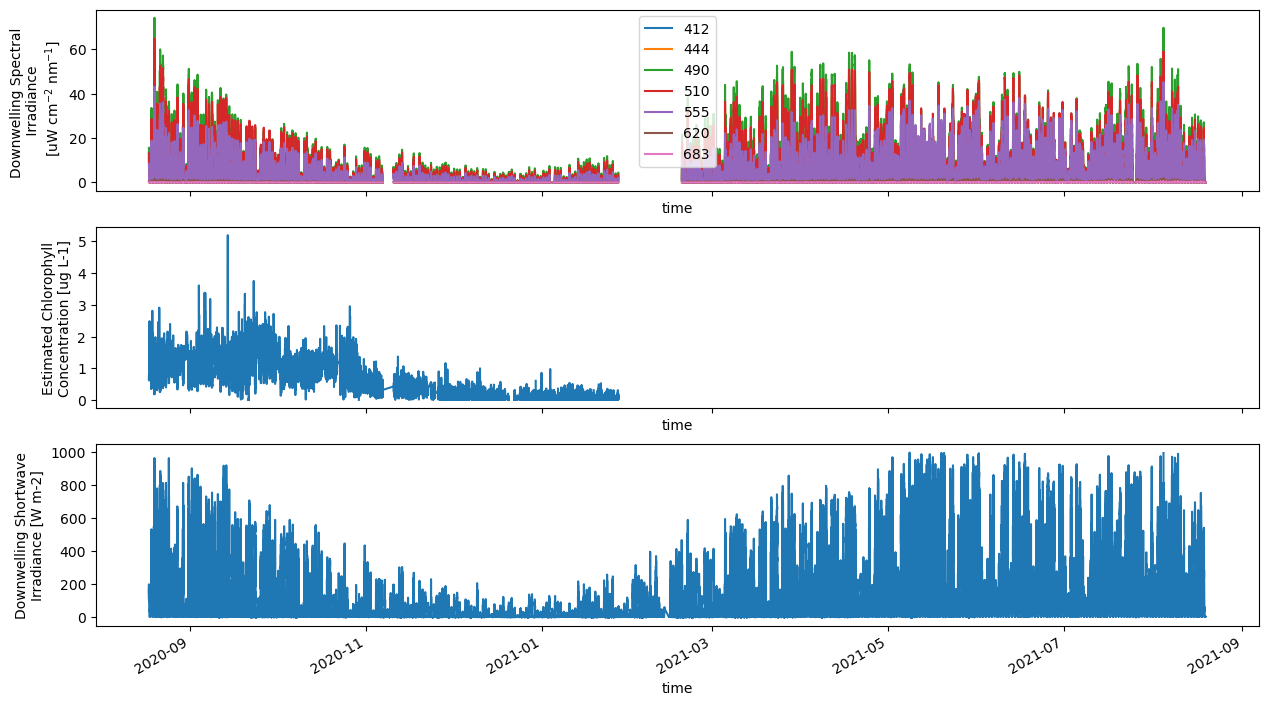

In [31]:
# Check behavior of shortwave irradiance and Chl-a during deployment
metbk, flort, fig, ax = check_chla_swr(spkir, site, deploy, flort_node)

### Deployment 8

I don't know that we necessarily need an annotation, but there is negative irradiance measured in the 683 nm channel.

In [58]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 8

In [59]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:07<00:00,  7.26s/it]


In [60]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [61]:
spkir = nanfill_time_gaps(spkir)

In [62]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 7093, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2021-08-19T07:00:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 11.5 11.5 ... nan nan
    input_voltage                  (station, time) float32 8.4 8.4 ... nan nan
    deployment                     (station, time) float32 8.0 8.0 ... nan nan
    analog_rail_voltage            (station, time) float32 5.34 5.34 ... nan nan
    raw_irradiance_412             (station, time) float32 2.148e+09 ... nan
    raw_irradiance_444             (station, time) float32 2.148e+09 ... nan
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 -0.006208 ... nan
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... nan nan
    station_name                   (station) <U8 'GI01SUMO'
    lat                            (station) float32 59.95
    lon                            (station) float32 -39.58
    z                              (station) float32 12.0
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            12.0
    geospatial_vertical_max:            12.0

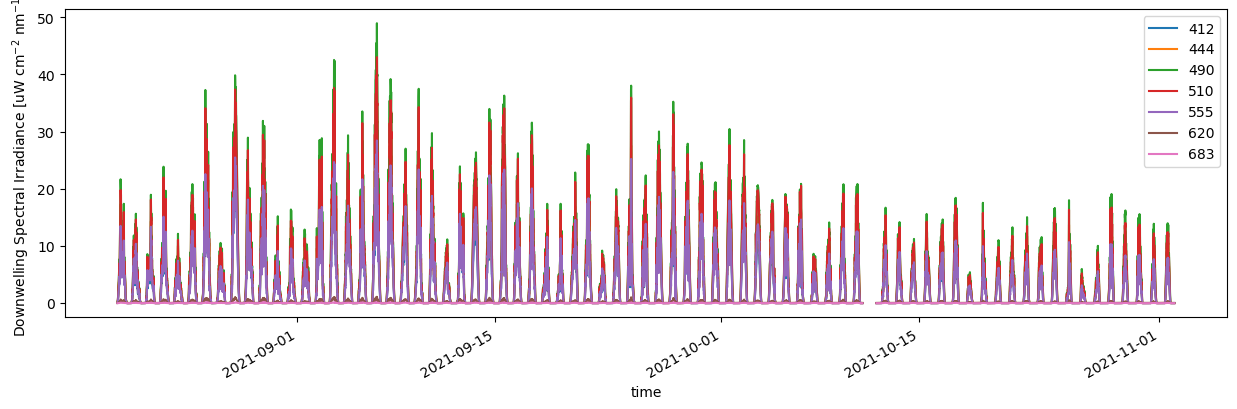

In [63]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

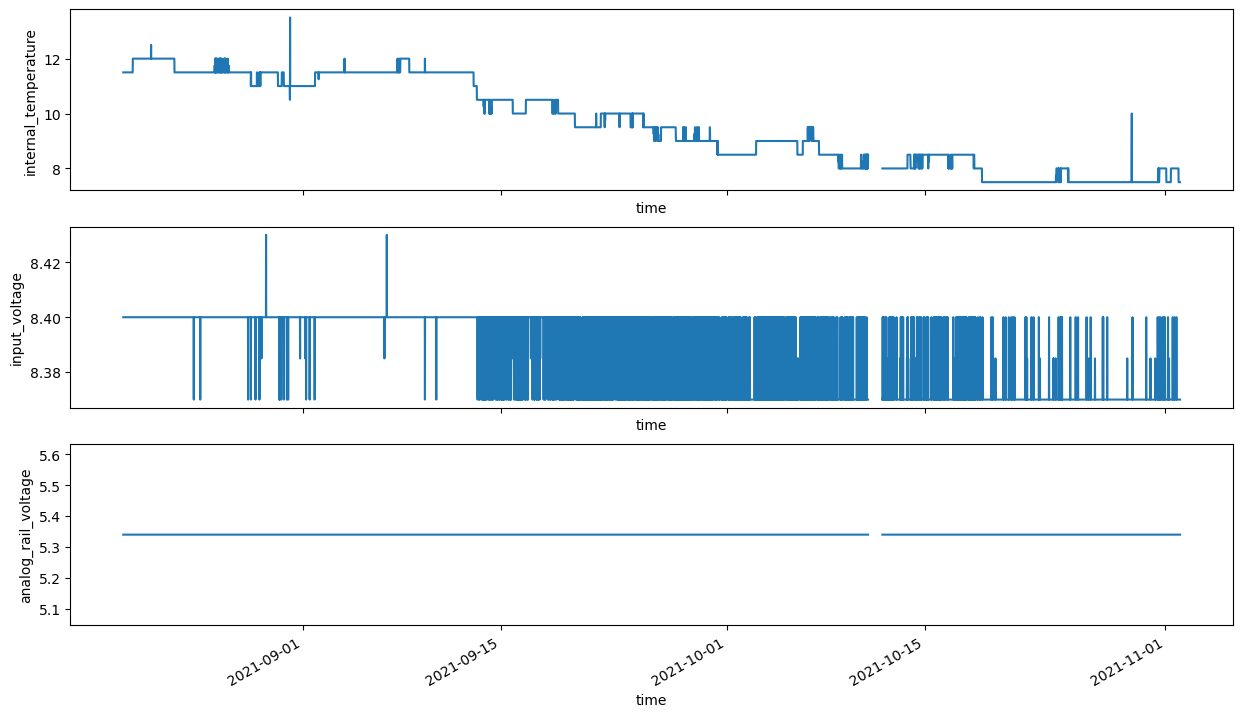

In [64]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

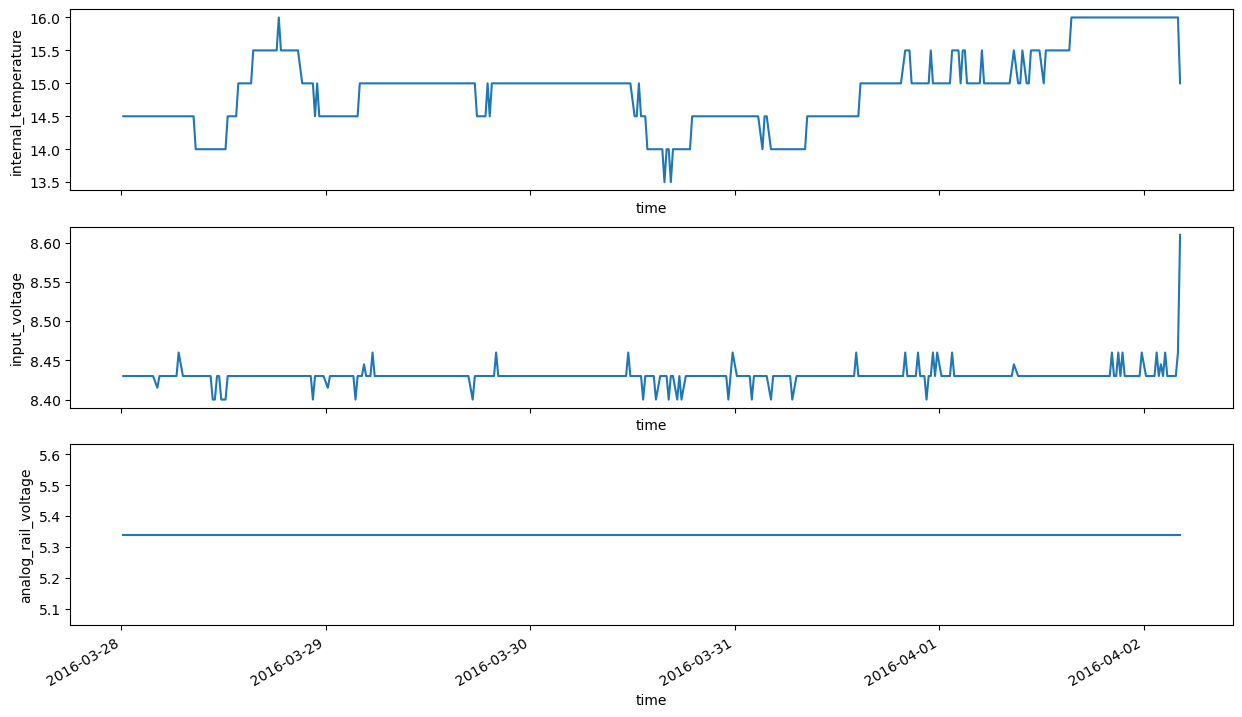

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Histograms of downwelling irradiance measurements

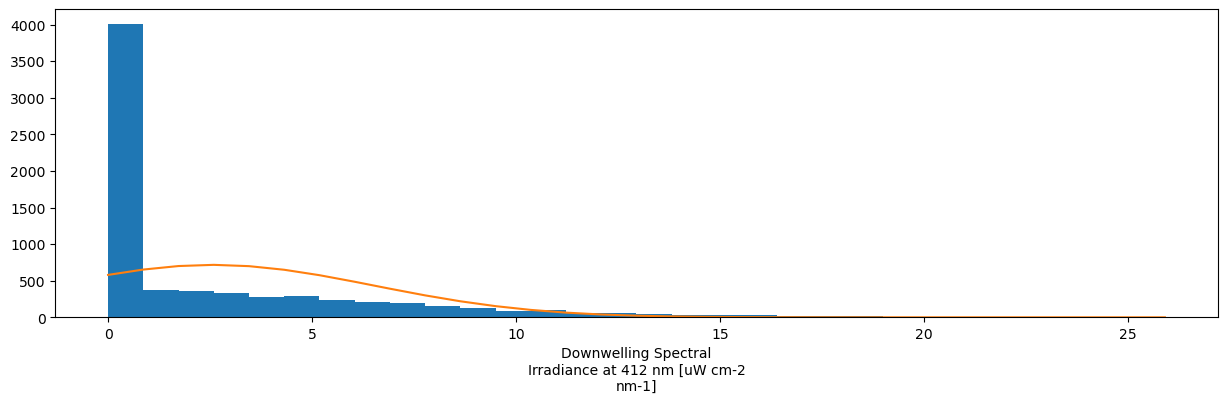

In [65]:
# histogram of downwelling irradiance @ 412 nm variable
irrad412 = spkir['downwelling_irradiance_412'][0]
# irrad412 = spkir['downwelling_irradiance_412'][0].sel(time=slice('2017-07-01'))
mu412 = irrad412.mean()
sig412 = irrad412.std()

plt.figure(figsize=(15,4))
c, x, h = irrad412.plot.hist(bins=30)
norm412 = sum(c)*norm.pdf(x, mu412, sig412)
plt.plot(x, norm412)

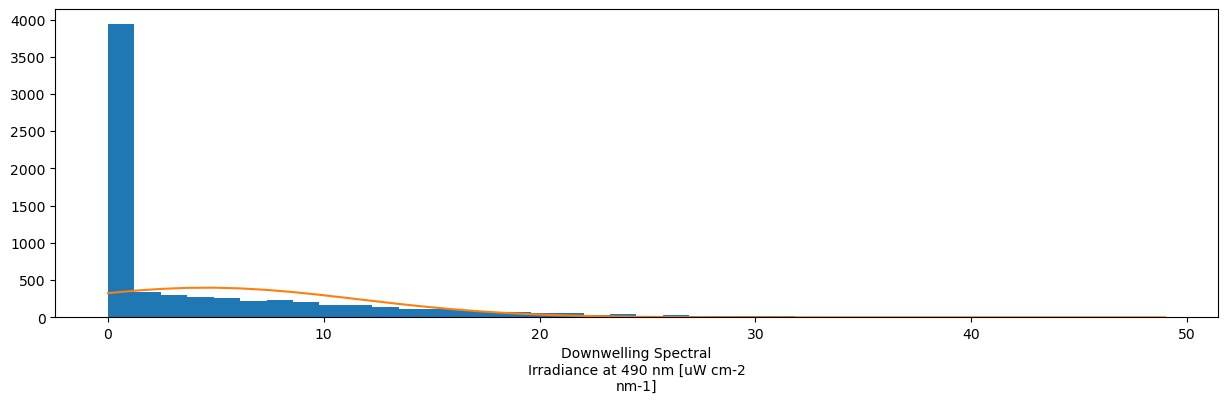

In [66]:
# histogram of downwelling irradiance @ 490 nm variable
irrad490 = spkir['downwelling_irradiance_490'][0]
# irrad490 = spkir['downwelling_irradiance_490'][0].sel(time=slice('2017-07-01'))
mu490 = irrad490.mean()
sig490 = irrad490.std()

plt.figure(figsize=(15,4))
c, x, h = irrad490.plot.hist(bins=40)
norm490 = sum(c)*norm.pdf(x, mu490, sig490)
plt.plot(x, norm490)

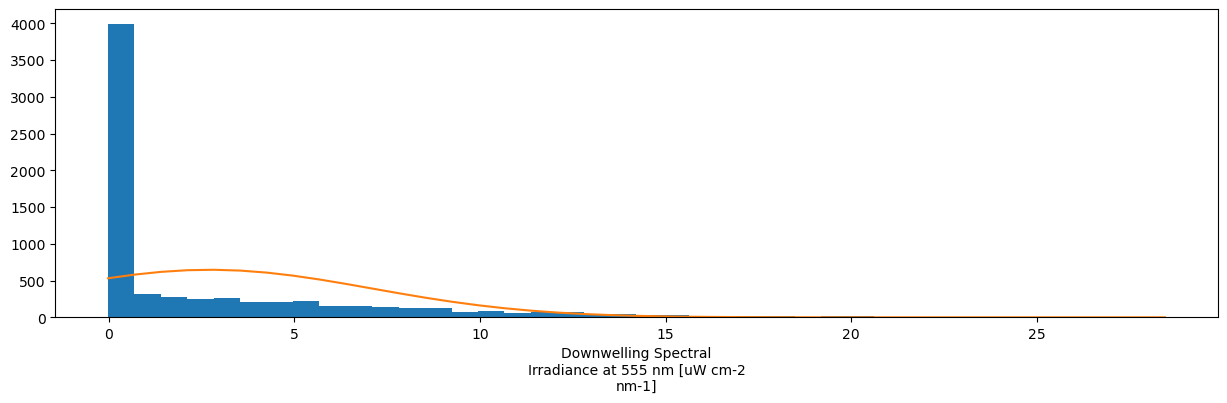

In [67]:
# histogram of downwelling irradiance @ 555 nm variable
irrad555 = spkir['downwelling_irradiance_555'][0]
# irrad555 = spkir['downwelling_irradiance_555'][0].sel(time=slice('2015-06-01'))
mu555 = irrad555.mean()
sig555 = irrad555.std()

plt.figure(figsize=(15,4))
c, x, h = irrad555.plot.hist(bins=40)
norm555 = sum(c)*norm.pdf(x, mu555, sig555)
plt.plot(x, norm555)

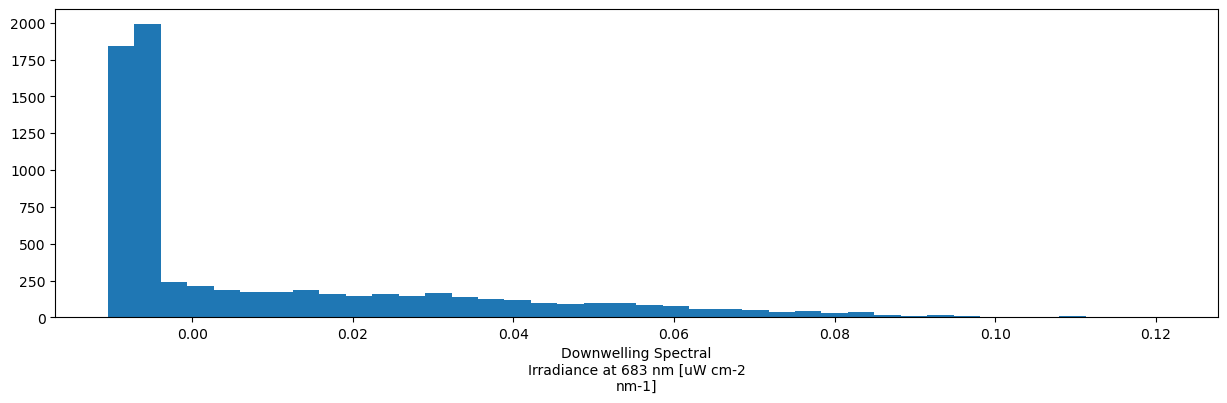

In [73]:
# histogram of downwelling irradiance @ 683 nm variable
irrad683 = spkir['downwelling_irradiance_683'][0]
# irrad683 = spkir['downwelling_irradiance_683'][0].sel(time=slice('2017-07-01'))
mu683 = irrad683.mean()
sig683 = irrad683.std()

plt.figure(figsize=(15,4))
c, x, h = irrad683.plot.hist(bins=40)
# norm683 = 0.05*sum(c)*norm.pdf(x, mu683, sig683)
# plt.plot(x, norm683)

In [69]:
# concat the different irradiance variables for histogram of all irradiance values
irradAll = xr.DataArray()
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        irradAll = xr.concat([irradAll, spkir[var][0]], dim='channel')
irradAll

<xarray.DataArray (channel: 8, time: 7093)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.10242978,  0.19699804,  0.28468522, ...,  0.00298528,
                nan,         nan],
       [ 0.1303979 ,  0.24975809,  0.35788769, ..., -0.00239106,
                nan,         nan],
       ...,
       [ 0.03876347,  0.09394369,  0.15571707, ..., -0.01806504,
                nan,         nan],
       [ 0.01620615,  0.01901813,  0.02087476, ...,  0.01754004,
                nan,         nan],
       [-0.00620844, -0.00594539, -0.0055508 , ..., -0.00741098,
                nan,         nan]])
Coordinates:
  * time     (time) datetime64[ns] 2021-08-19T07:00:00 ... 2021-11-02T02:00:00
Dimensions without coordinates: channel

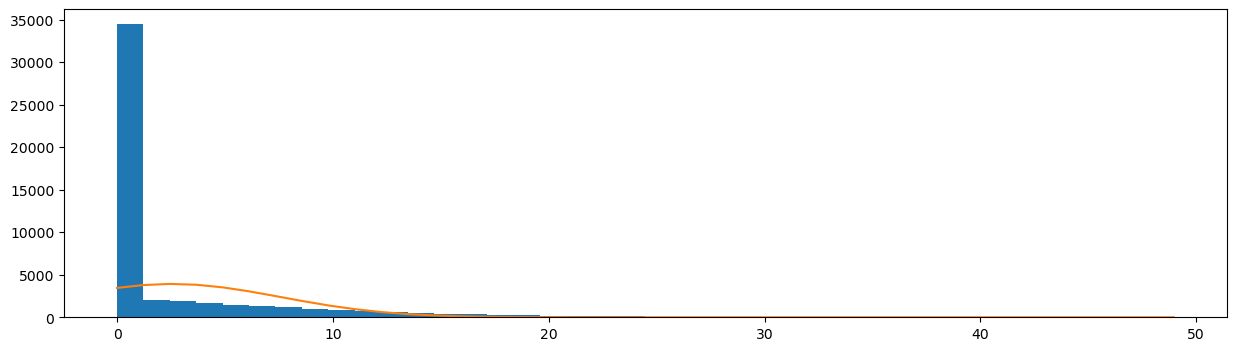

In [70]:
# histogram using all irradiance values
radAll= irradAll
muAll = radAll.mean()
sigAll = radAll.std()

plt.figure(figsize=(15,4))
c, x, h = radAll.plot.hist(bins=40)
normAll = sum(c)*norm.pdf(x, muAll, sigAll)
plt.plot(x, normAll)

### Histograms after monthly mean filter

### Spectrograms of downwelling irradiance (not burst averaged)

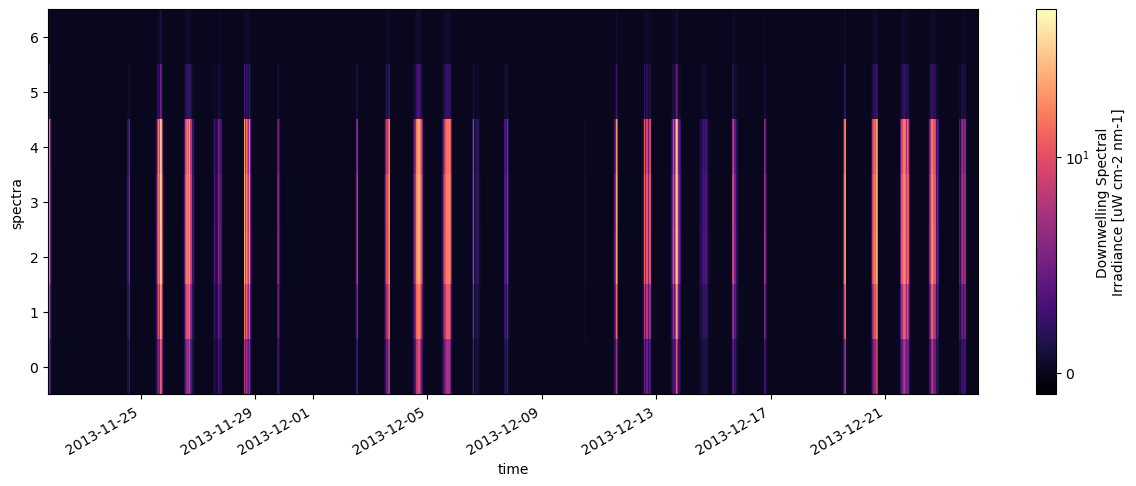

In [20]:
# Trying same plot with full resolution data with log-scale colormap (linear between -1,10)
xr.plot.pcolormesh(spkir_full_time.spkir_abj_cspp_downwelling_vector, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [28]:
# That was a bad idea so let's resample to daily
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="1D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 174, spectra: 7)>
array([[ 9.71255556e+00,  1.33028855e+01,  1.93817753e+01, ...,
         2.23164523e+01,  3.62021577e+00,  7.82912088e-01],
       [ 6.20054185e-01,  9.06080839e-01,  1.34600973e+00, ...,
         1.25914219e+00,  1.82409459e-01,  5.95385999e-02],
       [ 1.73746901e-01,  2.63608506e-01,  3.78101900e-01, ...,
         4.27118953e-01,  6.74665225e-02,  3.25888514e-02],
       ...,
       [ 7.39844170e-02,  7.86333704e-02,  8.35438973e-02, ...,
         5.61443408e-02,  8.31668786e-03,  4.77597635e-03],
       [ 2.28589437e-01,  2.76852485e-01,  3.28657073e-01, ...,
         2.09412793e-01,  2.62619446e-02,  1.17360818e-02],
       [ 2.29803754e-03,  3.92295552e-04, -2.80754229e-04, ...,
        -6.79578805e-04,  1.25565920e-03,  3.28846042e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-07 ... 2019-09-26
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

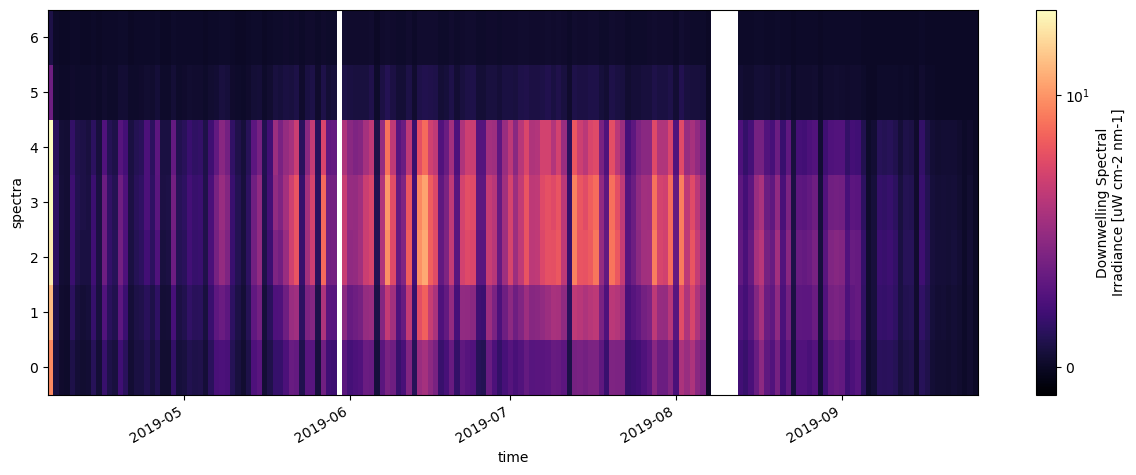

In [30]:
# pcolormesh plot with log-scale cmap except for [-1, 10] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [31]:
# Now lets try this with a 5-day median resample
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="5D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 35, spectra: 7)>
array([[6.82127204e-01, 9.39339140e-01, 1.49556243e+00, 1.66573864e+00,
        1.50775647e+00, 2.17019475e-01, 6.62599682e-02],
       [4.09351526e-01, 5.97971766e-01, 8.23282033e-01, 8.41685295e-01,
        7.24953008e-01, 1.07756459e-01, 4.46083474e-02],
       [1.11149060e+00, 1.63481436e+00, 2.06272259e+00, 1.99825457e+00,
        1.42778278e+00, 2.07900504e-01, 6.89136231e-02],
       [6.33905790e-01, 8.30168475e-01, 1.26737414e+00, 1.37036116e+00,
        1.22211412e+00, 1.81988724e-01, 5.88591173e-02],
       [4.88950510e-01, 7.05335209e-01, 1.08804481e+00, 1.18094031e+00,
        1.09429885e+00, 1.71634988e-01, 5.71144999e-02],
       [6.95715056e-01, 9.77443677e-01, 1.34453113e+00, 1.40168619e+00,
        1.25158622e+00, 1.94583331e-01, 6.10077514e-02],
       [1.77887788e+00, 2.40299210e+00, 3.25211386e+00, 3.32345650e+00,
        2.82799702e+00, 3.63398624e-01, 9.33474496e-02],
       [8.35149703e-01, 1.11870379e+00, 1.48298037e+00, 1.51192503e+00,
        1.28393037e+00, 1.92699171e-01, 5.95294177e-02],
       [1.19328147e+00, 1.70288643e+00, 2.52271664e+00, 2.78847411e+00,
        2.70395010e+00, 3.80136554e-01, 1.00454470e-01],
       [2.62830054e+00, 3.91435216e+00, 5.20132994e+00, 5.24724249e+00,
        4.42306642e+00, 5.73875815e-01, 1.45943075e-01],
...
       [2.06008457e+00, 2.58632186e+00, 3.16383481e+00, 2.98038643e+00,
        2.42941038e+00, 3.60160794e-01, 9.68550489e-02],
       [2.74753531e+00, 3.09858421e+00, 3.49182410e+00, 3.13586101e+00,
        2.39268108e+00, 3.07221372e-01, 8.25675502e-02],
       [2.20276612e+00, 2.58443371e+00, 2.88604360e+00, 2.58521177e+00,
        1.98243281e+00, 2.43159916e-01, 6.05670060e-02],
       [1.66826512e+00, 2.02154214e+00, 2.23259445e+00, 1.97611683e+00,
        1.40635816e+00, 1.69531314e-01, 4.33503864e-02],
       [2.70608963e+00, 3.34031155e+00, 3.58219552e+00, 3.11022829e+00,
        2.22732694e+00, 2.56595992e-01, 6.27982799e-02],
       [7.45937359e-01, 8.52196817e-01, 9.00792402e-01, 7.83724039e-01,
        6.10910023e-01, 8.67380087e-02, 2.31770994e-02],
       [1.05503826e+00, 1.35776975e+00, 1.46589740e+00, 1.28284831e+00,
        9.28877248e-01, 1.16683356e-01, 3.63260056e-02],
       [7.11412936e-01, 9.11214792e-01, 1.05646410e+00, 9.39103459e-01,
        7.16780233e-01, 8.74880143e-02, 2.91914385e-02],
       [3.15291575e-01, 3.98664721e-01, 4.91061523e-01, 4.47583359e-01,
        3.45641780e-01, 4.67864891e-02, 1.80901622e-02],
       [6.95465087e-03, 5.62515071e-03, 3.77377740e-03, 2.68314116e-03,
        3.17550394e-03, 3.19469816e-03, 4.37195968e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-11 ... 2019-09-23
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

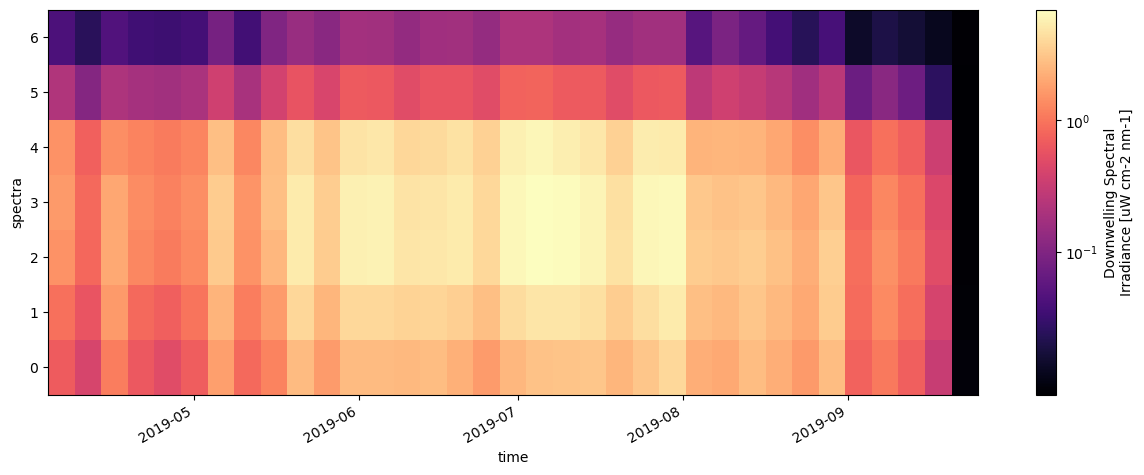

In [37]:
# 5-day median of downwelling spectral irradiance pcolormesh plot with log-scale cmap except for [0, 0.01] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=0.1))

### Check annotations to be added with time series

In [8]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]

In [9]:
# Request annotations and load data from the local kdata directory 
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*SPKIR*.nc'))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]


In [10]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations

In [11]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (station: 1, time: 208675)
Coordinates:
  * time                           (time) datetime64[ns] 2014-09-10T21:00:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 14.0 15.5 ... 13.0
    input_voltage                  (station, time) float32 8.46 8.46 ... 8.37
    deployment                     (station, time) float32 1.0 1.0 ... 9.0 9.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.31
    raw_irradiance_412             (station, time) float32 2.148e+09 ... 2.15...
    raw_irradiance_444             (station, time) float32 2.148e+09 ... 2.15...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 -0.0018 ... 0.2586
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'GI01SUMO'
    lat                            (station) float32 59.94
    lon                            (station) float32 -39.57
    z                              (station) float32 12.0
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            12.0
    geospatial_vertical_max:            12.0

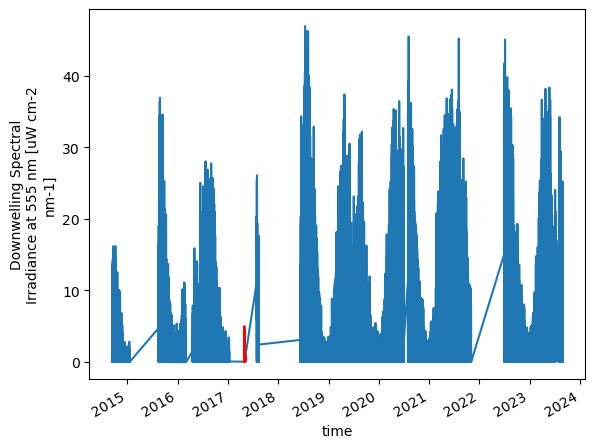

In [12]:
# Plot one SPKIR parameter with data where new annotations added in red
spkir.downwelling_irradiance_555.squeeze().plot()
spkir.downwelling_irradiance_555.sel(time=slice("2017-01-09T18:15:00", "2017-07-28T12:00:00")).plot(c="r")